In [1]:
import numpy as np
import matplotlib
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In order to run the code, the solution matrix including the calculations of each objective function for every feasible solution as derived from MATPOWER is required.  

The code in this notebook must be run once for each notepad file containing the solutions matrix for one time period. To obtain solutions for 3 time periods (morning, afternoon, evening), this code must be run 3 times, once for each of the 3 solution matrices written in 3 different notepad files.   

The solutions matrix will be of the following format:   

Column 1: Sum of all real power losses in the grid for each feasible solution  
Column 2: Sum of all real power losses in the grid for each feasible solution  
Column 3: Sum of voltage deviations in the grid for each feasible solution  
Column 4: Bus number of Solar PV DG placement in the grid for each feasible solution  
Column 5: Bus number of Solar PV DG placement in the grid for each feasible solution  
  
This solution matrix can be acquired from a notepad file (which is what is implemented here). For this, copy the path of the notepad file (enclosed in parentheses, and preceded with an r) in which this solution matrix has been written, within the brackets of the np.loadtxt() function below. A sample path is included below.  

For 2 DGs, which has been considered here, there should be 1024 feasible solutions, so the solution matrix will have dimensions of (1024,5). 

If the matrix written in notepad has more than 5 columns, this is acceptable, as the program will cut the matrix at 5 columns after reading the whole notepad file. However, it is necessary that the first 5 columns of the matrix are as per the format above.  

Once entering the notepad file path in the indicated format, run all the cells in the notebook to get their output.
All cells must be run in chronological order.

In [9]:
dataset = np.loadtxt('VLoadAfternoon.txt')
length = dataset.shape[0]

In [115]:
# Creating an array of indices to index the data
indices = np.reshape(np.arange(1,length + 1), (length,1))

# Concatenating this list of indices to the data valyes and creating the 'keys' array to match the bus combinations 
# With the indices
values = np.concatenate((np.reshape(dataset[:, 0:3], (length,3)), indices), axis=1);
keys = np.concatenate((np.reshape(dataset[:, 3:5], (length,2)), indices), axis=1);
sortedvalues = np.sort(values)

In [116]:
# sorting the array of values according to the P objective
sortedvalues = values[values[:,0].argsort(kind='mergesort')];

In [117]:
# Outputs 1 if x dominates y over the list of objectives defined from the number firstobj to finalobj

def dominates(x, y, firstobj, finalobj):
    dominates = 1
    equality = 1
    for i in range(firstobj - 1, finalobj):
        if x[i] > y[i]:
            dominates = 0
        if x[i] != y[i]:
            equality = 0
    return 1 if dominates == 1 and equality == 0 else 0


In [118]:
# When given array of solutions data, finds the non-dominated solutions of data

def ndsolutions(data, lo, hi):
    nds = []
    if lo == hi:
        nds.append(data[lo-1,:])
        return nds
    
    for i in range(lo-1, hi):
        dom = 1
        for j in range(lo-1, hi):
            if dominates(data[i,:], data[j,:], 1, 3) == 0 and i!=j:
                dom = 0;
        if dom == 1:
            nds.append(data[i,:])
    return nds


In [119]:
# Kung's algorithm function:
def paretofront(data, lo, hi):
    if hi <= lo:
        return data[lo-1,:]
    T = paretofront(data, lo, lo + ((hi - lo)//2))
    P = paretofront(data, lo + ((hi - lo)//2) + 1, hi)
    ndsol = ndsolutions(data,  lo + ((hi - lo)//2) + 1, hi)
    array = np.copy(T)
    for i in range(0, len(ndsol)):
        dom = 1;
        for j in range(lo-1, int(lo + ((hi - lo)/2))):
            if dominates(data[j,:], ndsol[i], 1, 3) == 1:
                dom == 0;
        if dom == 1:
            array = np.concatenate((array, ndsol[i]), axis=0)
    return array


In [120]:
# Applying Kung's algorithm to find the pareto front of the given solution array

pfront = paretofront(sortedvalues, 1, length)
pfront = pfront.reshape((-1, 4))

In [121]:
# Separating the pareto front from the rest of the solutions to prepare it for plotting, or creating an array which consists
# of all solutions aside from the pareto front

pindices = np.sort(pfront[:, -1])
X = np.copy(values) 
k = 0
for i in pindices:
    X = np.delete(X, int(i-1-k) ,0)
    k=k+1

X1 = X[:,0]
X2 = X[:,1]
X3 = X[:,2]

Y1 = pfront[:,0]
Y2 = pfront[:,1]
Y3 = pfront[:,2]

To generate the 3D plot where the Pareto front is in blue and the remaining solutions are in red, along the axes of the 3 objective functions, run the cell below.

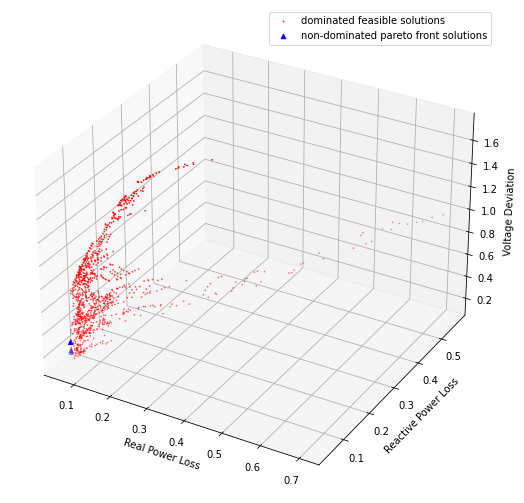

In [122]:
# Creating a 3D plot where the Pareto front is in blue and the remaining solutions are in red

fig = plt.figure(figsize = (16, 9))
ax = fig.add_subplot(111, projection='3d')
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.3,
        alpha = 0.2)
 
ax.scatter(X1, X2, X3, s = 0.5, c='r', marker='o', label="dominated feasible solutions")
ax.scatter(Y1, Y2, Y3, s = 20, c='b', marker='^', label="non-dominated pareto front solutions")

plt.legend()
ax.set_xlabel('Real Power Loss')
ax.set_ylabel('Reactive Power Loss')
ax.set_zlabel('Voltage Deviation')

plt.show()

In [123]:
#To find the least crowded solution, if the number of solutions in the pareto front is greater than 3

if pfront.shape[0] > 3:
    pfrontsorted = np.zeros((pfront.shape[0],6))
    k = 0
    for i in range(0,3):
        p = pfront[pfront[:,i].argsort(kind='mergesort')]
        pfrontsorted[:,i+k] = p[:,i]
        pfrontsorted[:,i+k+1] = p[:,3]
        k=k+1
    
#arrays to store crowding distances for examples not at the ends of pfront and their indices, for each objective function
    crowdingdist1 = np.zeros((pfront.shape[0]-2,2))
    crowdingdist2 = np.zeros((pfront.shape[0]-2,2))
    crowdingdist3 = np.zeros((pfront.shape[0]-2,2))
    denominators = np.zeros(pfront.shape[1]-1)

    # Denominators stores the maximum - minimum value of each objective function to use in the crowding distance formula
    for i in range(0,denominators.shape[0]):
        denominators[i] = np.amax(sortedvalues[:,i]) - np.amin(sortedvalues[:,i])

    # Applying the crowding distance formula
    for i in range(1, pfront.shape[0]-1):
        crowdingdist1[i-1,0] = (pfrontsorted[i+1,0] - pfrontsorted[i-1,0])/ denominators[0]
        crowdingdist1[i-1,1] = pfrontsorted[i,1]
        crowdingdist2[i-1,0] = (pfrontsorted[i+1,2] - pfrontsorted[i-1,2])/ denominators[1]
        crowdingdist2[i-1,1] = pfrontsorted[i,3]
        crowdingdist3[i-1,0] = (pfrontsorted[i+1,4] - pfrontsorted[i-1,4])/ denominators[2]
        crowdingdist3[i-1,1] = pfrontsorted[i,5]

    crowdingdist1 = crowdingdist1[crowdingdist1[:,1].argsort(kind='mergesort')]  
    crowdingdist2 = crowdingdist2[crowdingdist2[:,1].argsort(kind='mergesort')]
    crowdingdist3 = crowdingdist3[crowdingdist3[:,1].argsort(kind='mergesort')]

    crowdingdist = np.reshape(crowdingdist1[:,0] + crowdingdist2[:,0] + crowdingdist3[:,0], (crowdingdist1.shape[0],1))
    crowdingdist = np.concatenate((crowdingdist, np.reshape(crowdingdist1[:,1], (crowdingdist1.shape[0],1))), axis=1)

    # Sort the crowdingdist array to find the maximum crowding distance
    crowdingdist = crowdingdist[crowdingdist[:,0].argsort(kind='mergesort')]

In [124]:
#Find the buses corresponding to our optimal solutions, including that with the largest crowding distance:
if pfront.shape[0] > 3:
    optimalsolutions = np.zeros((3,2))

    optimalsolutions[0,:] = keys[int(crowdingdist[-1,1])-1,0:-1]
    optimalsolutions[1,:] = keys[int(pfront[0,-1])-1,0:-1]
    optimalsolutions[2,:] = keys[int(pfront[-1,-1])-1,0:-1]
else:
    optimalsolutions = np.zeros((pfront.shape[0],2))
    for i in range(0, pfront.shape[0]):
        optimalsolutions[i,:] = keys[int(pfront[i,-1])-1,0:-1]

The final output of our code is the optimal solutions array. The optimalsolutions array contains the bus combinations for optimal Solar PV and Wind DG placement for the time period in consideration, which is the output of this project. 
To print the array and hence to print the optimal solutions, run the cell below.  
It is an array of 1-3 pairs of numbers. Within each pair, the first is the bus number of the placement of the Solar PV DG and the second is the bus number of the placement of the Wind DG.

In [125]:
 print(optimalsolutions)

[[30.  9.]
 [30. 10.]
 [30. 11.]]
